In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_clean = pd.read_csv('../data/clean.csv')

# Data Visualization 

**SVMs rely on separating variables through boundaries, so it's helpful to examine pieces of the data in 2D to visualize how these boundaries may be drawn and how the feature importances may play out.**

In [21]:
df_graph = df_clean.copy()
df_graph['classification'] = df_graph['classification'].map({0: "CKD Negative", 1:"CKD Positive"})

### Hemoglobin & Serum Creatinine

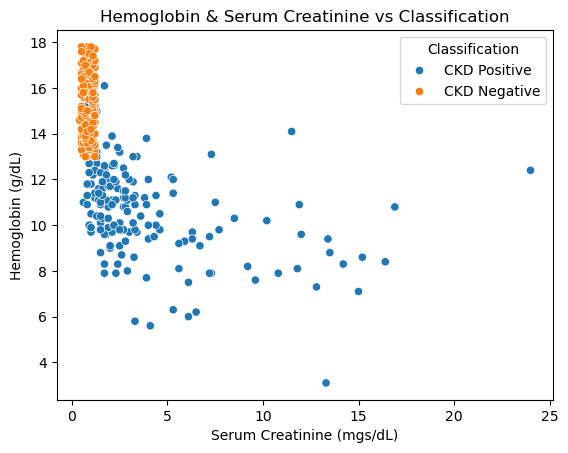

In [22]:
sns.scatterplot(data = df_graph, x = 'sc', y = 'hemo', hue = 'classification')
plt.title("Hemoglobin & Serum Creatinine vs Classification")
plt.legend(title = "Classification")
plt.xlabel("Serum Creatinine (mgs/dL)")
plt.ylabel("Hemoglobin (g/dL)")
plt.savefig("../figures/data_visualization/hemo&sc_classification.png", dpi=300, bbox_inches='tight')
plt.show()

**These two variables had the highest feature importances in random forest & logistic regression, and just by looking at the graph, it's evident that a straight line will be able to get almost perfectly separated groups (linearly seperable data).**

### Hemoglobin & Diabetes Mellitus

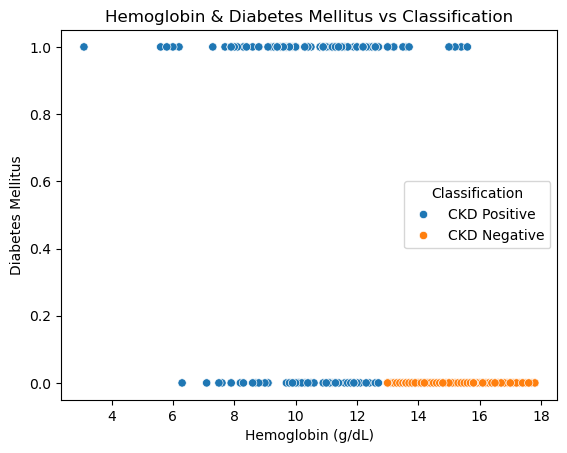

In [23]:
sns.scatterplot(data=df_graph, x='hemo', y='dm', hue='classification')
plt.title("Hemoglobin & Diabetes Mellitus vs Classification")
plt.legend(title = "Classification")
plt.ylabel("Diabetes Mellitus")
plt.xlabel("Hemoglobin (g/dL)")
plt.savefig("../figures/data_visualization/hemo&dm_classification.png", dpi=300, bbox_inches='tight')
plt.show()

**In this second example, a top indicator from previous models (hemo) is compared to a secondary indicator (dm). The graph looks linearly separable, and showcases how dm might even be a more important factor than hemoglobin in SVMs specifically, due to the feature importance being based on how it draws boundaries. Since patients with normal levels of hemoglobin who have diabetes are still classified as CKD positive, dm is likely a more telling factor in SVMs (the model below shows this, supporting this theory).**

### Diabetes Mellitus & Blood Glucose (Random)

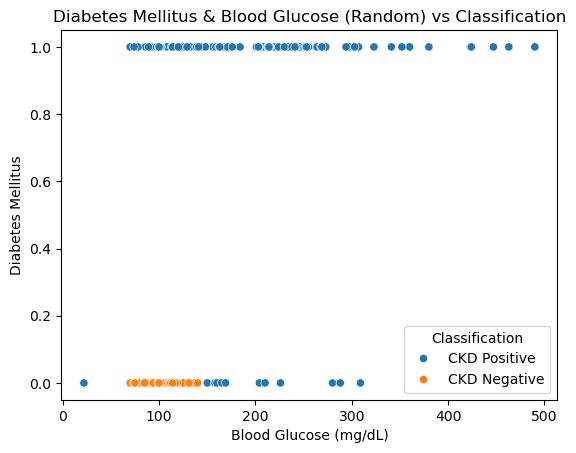

In [24]:
sns.scatterplot(data=df_graph, x='bgr', y='dm', hue='classification')
plt.title("Diabetes Mellitus & Blood Glucose (Random) vs Classification")
plt.legend(title = "Classification")
plt.ylabel("Diabetes Mellitus")
plt.xlabel("Blood Glucose (mg/dL)")
plt.savefig("../figures/data_visualization/dm&bgr_classification.png", dpi=300, bbox_inches='tight')
plt.show()

**This graph showcases why variables like blood glucose were consistently ranked low in all the models; the noisiness of the data makes it hard to draw any real conclusions. A binary chronic diagnosis, however, is much more telling and earns a higher feature importance.**

# Support Vector Machine Classifier (all select features)

**Check the logistic regression notebook for train-test split annotations.**

In [25]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X = df_clean[['hemo', 'sc', 'htn', 'dm', 'bp', 'bgr', 'age']]
y = df_clean['classification']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 18,
    stratify = y
)

### Linear Kernel 

**From the scatterplots, the data looked very linearly separable (even if we examined only pieces at a time), so the linear kernel was tried first. It also requires less tuning (no gamma) and requires less computational power, so it's optimal in this case. C was tuned to 10, which is a moderate increase and shouldn't pose too many overfitting concerns.**

In [26]:
model = SVC(
    random_state = 18,
    kernel = 'linear',
    C = 10
)
model.fit(X_train, y_train)

,C,10
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [27]:
y_predict = model.predict(X_test)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        27
           1       0.97      1.00      0.98        32

    accuracy                           0.98        59
   macro avg       0.98      0.98      0.98        59
weighted avg       0.98      0.98      0.98        59



In [28]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Accuracy per Fold:", scores)
print("Mean accuracy:", np.mean(scores))

Accuracy per Fold: [0.96610169 0.98305085 0.94915254 1.         0.98275862]
Mean accuracy: 0.9762127410870836


# Feature Importances

In [29]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0]
})

feature_importance['AbsCoeff'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='AbsCoeff', ascending=False)
feature_importance

,Feature,Coefficient,AbsCoeff
1,sc,4.958272,4.958272
2,htn,3.664656,3.664656
3,dm,3.664656,3.664656
0,hemo,-2.661889,2.661889
6,age,-0.128111,0.128111
5,bgr,0.091225,0.091225
4,bp,0.043108,0.043108


**As suspected, it seems like variables like dm and htn that allow the model to draw cleaner boundaries have a higher feature importance. Serum creatinine also allowed for this, and more so than hemoglobin, which has more spread (the first graph in this notebook showcases this). This tells us that there's redundancy in the data, which is good because models can be optimized based on which variables are available. In a case where hemo levels might not be obtainable, an SVM should perform better than the other models.**

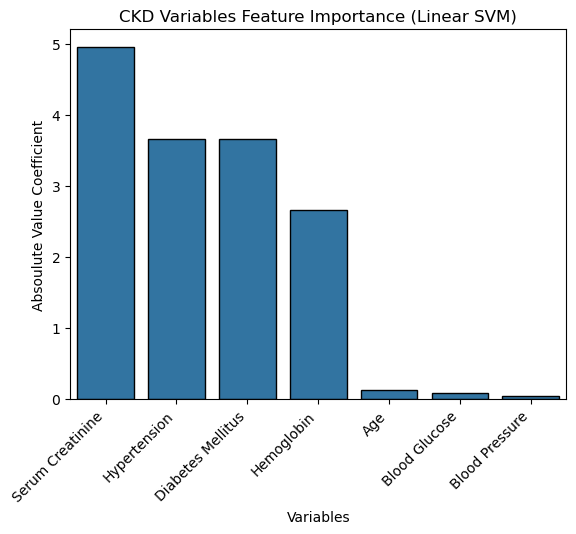

In [30]:
sns.barplot(
    data = feature_importance,
    x = 'Feature',
    y = 'AbsCoeff',
    capsize=0.2,
    edgecolor='black'
)
plt.title('CKD Variables Feature Importance (Linear SVM)')
plt.xlabel('Variables')
plt.ylabel('Absoulute Value Coefficient')
plt.xticks(['htn', 'sc', 'hemo', 'bp', 'age', 'bgr', 'dm'], ["Hypertension", "Serum Creatinine", "Hemoglobin", "Blood Pressure", "Age", "Blood Glucose", "Diabetes Mellitus"])
plt.xticks(rotation=45, ha="right")
plt.savefig("../figures/feature_importance/SVM_linear_Feature_Importance.png", dpi=300, bbox_inches='tight')
plt.show()

### RBF Kernel

**RBF is included here just to showcase it's not optimal for this set. Most of the data is linearly separable, and if an RBF were used, it would need more rigorous gamma tuning to be able to perform at the same metrics or worse. In this case, it's not worth going deeper into, but it may be in the future when more datasets are incorporated or if the distribution is different for new variables.**

In [31]:
model_1 = SVC(
    random_state = 18,
    kernel = 'rbf',
    C = 1,
)
model_1.fit(X_train, y_train)

,C,1
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [32]:
y_predict_1 = model_1.predict(X_test)

print(classification_report(y_test, y_predict_1))

              precision    recall  f1-score   support

           0       0.62      0.89      0.73        27
           1       0.85      0.53      0.65        32

    accuracy                           0.69        59
   macro avg       0.73      0.71      0.69        59
weighted avg       0.74      0.69      0.69        59



In [33]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model_1, X, y, cv=5, scoring='accuracy')
print("Accuracy per Fold:", scores)
print("Mean accuracy:", np.mean(scores))

Accuracy per Fold: [0.71186441 0.83050847 0.81355932 0.77586207 0.81034483]
Mean accuracy: 0.7884278199883109


# ROC Curve & AUC Score (Linear Kernel)

In [34]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_predict)

roc_auc = auc(fpr, tpr)

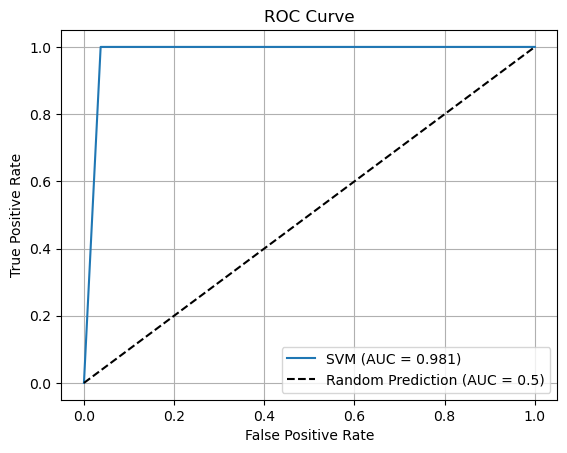

In [35]:
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Prediction (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.savefig("../figures/roc_auc/SVM_ROC.png", dpi=300, bbox_inches='tight')
plt.show()